In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-17 12:06:56.569267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 12:06:57.075371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-17 12:06:57.617123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 12:06:57.640370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.793473,36.825,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.793993,34.088,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.794514,30.150,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.795034,31.224,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.795555,33.606,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


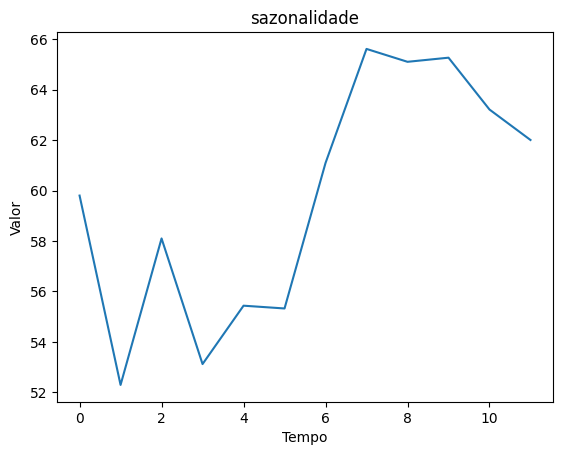

,sazonalidade
sazonalidade,
0,59.798725
1,52.289793
2,58.098576
3,53.116962
4,55.432047
5,55.321868
6,61.091975
7,65.614959
8,65.103883


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.793473,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,59.798725,36.825
1,2003-2,0.793993,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,52.289793,34.088
2,2003-3,0.794514,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,58.098576,30.150
3,2003-4,0.795034,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,53.116962,31.224
4,2003-5,0.795555,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,55.432047,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.432047,NaN
245,2023-6,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.321868,NaN
246,2023-7,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.091975,NaN
247,2023-8,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.614959,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 249, dtype: float64

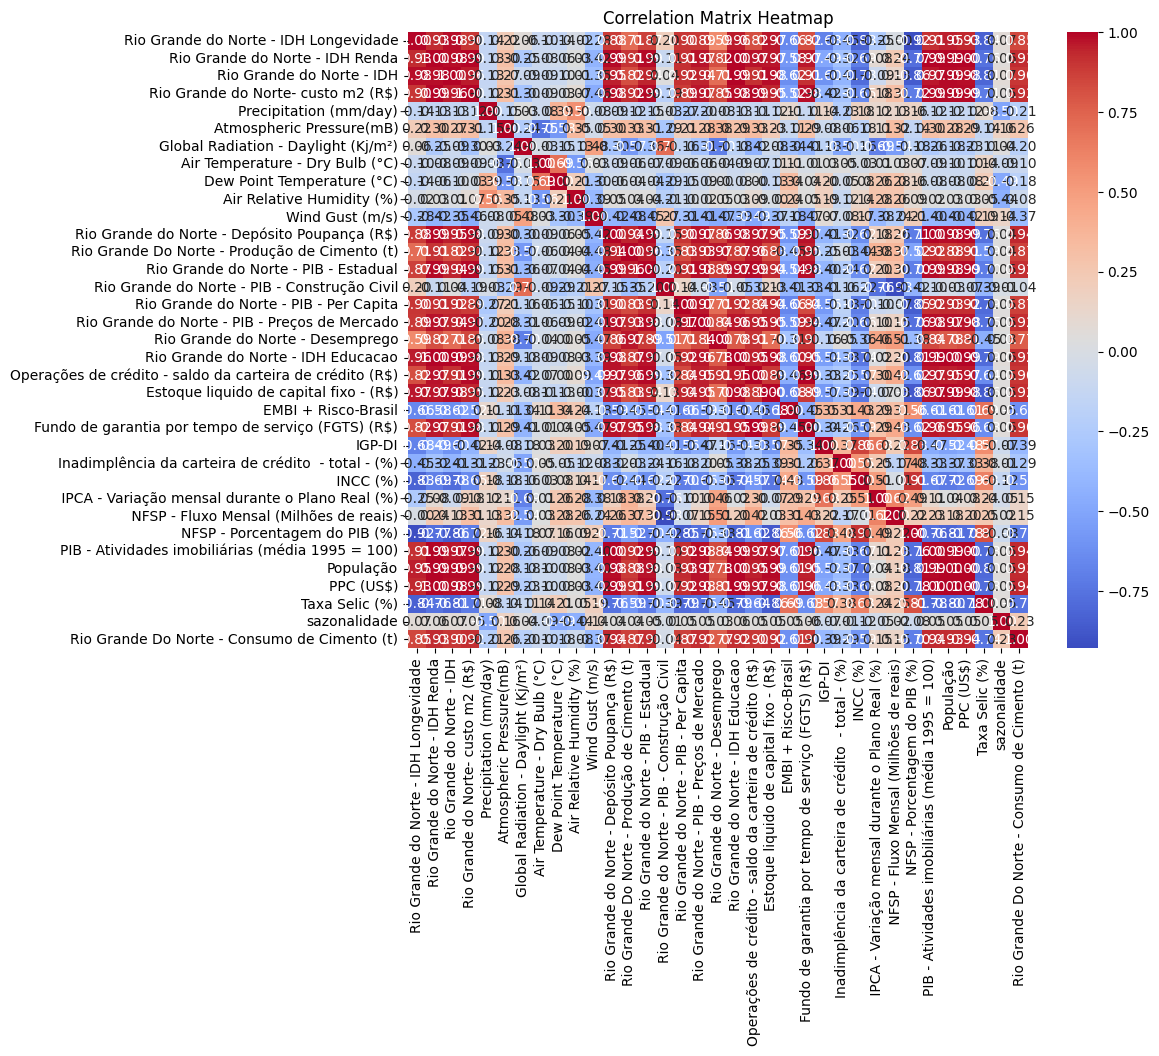

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Norte - IDH Longevidade,1.408027e+07
1,Rio Grande do Norte - IDH Renda,1.054794e+10
2,Rio Grande do Norte - IDH,9.079838e+11
3,Rio Grande do Norte- custo m2 (R$),3.890342e+06
4,Precipitation (mm/day),1.021522e+02
5,Atmospheric Pressure(mB),5.183613e+07
6,Global Radiation - Daylight (Kj/m²),1.442151e+02
7,Air Temperature - Dry Bulb (°C),1.795278e+07
8,Dew Point Temperature (°C),1.311907e+07
9,Air Relative Humidity (%),7.089728e+06


In [14]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  'sazonalidade'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9944.060800,1.853436,8770.488958,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,8.294170,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,59.798725
1,10034.559262,1.852423,8770.488958,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,8.288224,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,52.289793
2,10120.152965,1.851832,8770.488958,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,8.282278,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,58.098576
3,10199.169751,1.851769,8770.488958,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,8.276332,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,53.116962
4,10272.393199,1.893568,8100.094916,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,8.270387,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,55.432047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,20182.842138,1.166980,1662.653569,21.484201,75.844545,4.344405,3.769281e+06,104.685886,3.741441e+07,1.978816e+06,13.481020,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,65.614959
152,20277.786620,1.108430,1724.005477,21.578311,74.841423,4.384533,3.757255e+06,103.883769,3.743071e+07,1.976415e+06,13.478039,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,65.103883
153,20370.142537,1.119029,1711.770316,21.894005,75.203397,4.229435,3.745229e+06,102.987295,3.744702e+07,1.974013e+06,13.475059,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,65.267355
154,20461.733612,1.125827,1725.259590,22.265518,75.708224,4.135110,3.733204e+06,101.964874,3.746333e+07,1.971611e+06,13.472078,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,63.211432


In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.265543,-0.177872,-0.262539,-0.274889,0.780101,-1.594791,-0.988537,-1.594817,-1.601581,-0.661348,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,0.263562,-0.177872,-0.261578,-0.273828,0.776572,-1.576742,-0.997249,-1.572797,-1.532384,-0.663910,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.262407,-0.177872,-0.261018,-0.273209,0.774514,-1.558694,-0.998153,-1.550778,-1.463188,-0.666472,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,0.262283,-0.177872,-0.260958,-0.273143,0.774293,-1.540646,-0.993220,-1.528758,-1.393991,-0.669035,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,0.343972,-0.255153,0.044687,0.025362,0.529441,-1.522598,-0.981171,-1.506738,-1.324795,-0.671597,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-1.076011,-0.997245,-0.470753,0.189881,-0.527748,1.256712,1.315378,1.540229,-2.163692,1.573975,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,-1.190436,-0.990172,-0.287982,-0.288618,-0.488071,1.238907,1.291374,1.549096,-2.231708,1.572690,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,-1.169722,-0.991583,0.325126,-0.115952,-0.641424,1.221102,1.264546,1.557964,-2.299725,1.571406,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,-1.156437,-0.990028,1.046642,0.124855,-0.734688,1.203296,1.233949,1.566832,-2.367742,1.570122,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.265543,-0.177872,-0.262539,-0.274889,0.780101,-1.594791,-0.988537,-1.594817,-1.601581,-0.661348,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,0.263562,-0.177872,-0.261578,-0.273828,0.776572,-1.576742,-0.997249,-1.572797,-1.532384,-0.663910,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.262407,-0.177872,-0.261018,-0.273209,0.774514,-1.558694,-0.998153,-1.550778,-1.463188,-0.666472,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,0.262283,-0.177872,-0.260958,-0.273143,0.774293,-1.540646,-0.993220,-1.528758,-1.393991,-0.669035,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,0.343972,-0.255153,0.044687,0.025362,0.529441,-1.522598,-0.981171,-1.506738,-1.324795,-0.671597,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.082740,-1.001805,-0.671695,0.610188,-0.500665,1.451069,1.485343,1.407078,-1.343587,1.537970,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,-0.018746,-0.997704,-0.440199,0.451082,-0.484824,1.437125,1.475569,1.421293,-1.412384,1.546969,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,-0.453386,-0.992748,-0.312381,-0.030213,-0.445067,1.423181,1.464878,1.435509,-1.481182,1.555968,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,-0.287378,-0.992198,0.096241,-0.157197,-0.557813,1.409237,1.453680,1.449724,-1.549979,1.564967,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      38.146000
1      30.350000
2      33.791000
3      30.891000
4      30.724000
         ...    
139    74.307151
140    73.816512
141    73.973447
142    71.999738
143    63.088500
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 144, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 22)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,-0.373132,-0.878192,-0.152167,-0.959842,-0.513105,0.618342,0.945833,0.797268,0.792986,1.205245,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,-0.017995,-0.919013,0.063949,-0.672570,-0.527662,0.664191,1.001626,0.821697,0.742119,1.214721,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.306891,-0.952807,0.116595,-0.124243,-0.641030,0.710040,1.059405,0.846126,0.691253,1.224197,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.338878,-0.976807,-0.184000,0.301121,-0.673004,0.755889,1.109149,0.870555,0.640387,1.233673,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.248202,-0.990763,-0.820737,0.560704,-0.585508,0.801738,1.162349,0.894984,0.589520,1.243149,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,-0.281361,-0.994619,-1.377584,0.477409,-0.425262,0.847587,1.210496,0.919413,0.538654,1.252625,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,-0.855663,-0.990549,-1.863969,-0.030946,-0.168408,0.893437,1.254505,0.943842,0.487788,1.262101,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,-1.475889,-0.983045,-2.050580,-0.673498,-0.129072,0.939286,1.295906,0.968271,0.436921,1.271577,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,-1.870556,-0.978642,-1.778821,-1.178581,-0.142437,0.985135,1.331085,0.992700,0.386055,1.281053,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,-1.936810,-0.977398,-1.386436,-1.459576,-0.245757,1.030984,1.345277,1.017129,0.335189,1.290529,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 22)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [23]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(104, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [24]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [25]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2590628789, 75960832, 954435223, 1259756342, 3811656013, 1883813108, 1221318363, 3437129561, 3890100616, 4293917686]


Step: 0 ___________________________________________


2023-11-17 12:06:59.978689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 12:06:59.978906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 12:06:59.979080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 3.9558820724487305
winner_seed: 2590628789


Step: 1 ___________________________________________
val_loss: 11.45576286315918


Step: 2 ___________________________________________
val_loss: 7.131399154663086


Step: 3 ___________________________________________
val_loss: 5.17889404296875


Step: 4 ___________________________________________
val_loss: 29.690824508666992


Step: 5 ___________________________________________
val_loss: 9.057722091674805


Step: 6 ___________________________________________
val_loss: 10.688642501831055


Step: 7 ___________________________________________
val_loss: 13.306840896606445


Step: 8 ___________________________________________
val_loss: 8.0516357421875


Step: 9 ___________________________________________
val_loss: 7.841724395751953


final_seed: 2590628789


In [26]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2652417522

Epoch 1/10000
4/4 [==============================] - 2s 121ms/step - loss: 4775.8516 - val_loss: 59.2135
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 165.7684 - val_loss: 24.6034
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 151.5119 - val_loss: 264.5693
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 191.4764 - val_loss: 25.0506
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 156.7103 - val_loss: 73.4554
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 153.1121 - val_loss: 46.5177
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 136.5729 - val_loss: 29.4673
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 120.4955 - val_loss: 113.2743
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 132.4412 - val_loss: 28.4852
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 1

4/4 [==============================] - 0s 8ms/step - loss: 25.1287 - val_loss: 14.1536
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.5384 - val_loss: 50.5857
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.1259 - val_loss: 11.5939
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.6961 - val_loss: 11.0837
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.0442 - val_loss: 12.5067
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.6650 - val_loss: 14.7078
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 22.9016 - val_loss: 12.7320
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.9918 - val_loss: 16.4142
Epoch 89/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.0899 - val_loss: 60.5899
Epoch 90/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.5898 - val_loss: 1

Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.3968 - val_loss: 14.1319
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.5265 - val_loss: 9.0473
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.1725 - val_loss: 7.9316
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.7945 - val_loss: 11.9361
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.5283 - val_loss: 11.4605
Epoch 166/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.6681 - val_loss: 22.3467
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.0486 - val_loss: 10.7108
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.9646 - val_loss: 13.8889
Epoch 169/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.4641 - val_loss: 13.7226
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 

Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.7728 - val_loss: 16.5551
Epoch 242/10000
4/4 [==============================] - 0s 8ms/step - loss: 22.4882 - val_loss: 11.6368
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.1734 - val_loss: 12.6358
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.4674 - val_loss: 42.4045
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.7297 - val_loss: 9.8725
Epoch 246/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.4456 - val_loss: 16.0242
Epoch 247/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.4293 - val_loss: 9.2499
Epoch 248/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.6198 - val_loss: 6.8982
Epoch 249/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.2810 - val_loss: 11.3865
Epoch 250/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 8ms/step - loss: 18.9846 - val_loss: 9.0464
Epoch 321/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.1585 - val_loss: 24.7941
Epoch 322/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.3844 - val_loss: 73.5118
Epoch 323/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.2665 - val_loss: 32.1923
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5502 - val_loss: 25.9564
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.4344 - val_loss: 19.2961
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.5299 - val_loss: 9.2077
Epoch 327/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.2508 - val_loss: 30.9785
Epoch 328/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.8957 - val_loss: 16.8394
Epoch 329/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.9637 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 15.0347 - val_loss: 37.5609
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.2383 - val_loss: 36.8432
Epoch 401/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.8075 - val_loss: 10.1964
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.1094 - val_loss: 18.6241
Epoch 403/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.4978 - val_loss: 13.6230
Epoch 404/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.7582 - val_loss: 22.7303
Epoch 405/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7686 - val_loss: 8.9797
Epoch 406/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.3599 - val_loss: 10.9896
Epoch 407/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.8931 - val_loss: 27.6938
Epoch 408/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.2250 - val_l

Epoch 479/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.3987 - val_loss: 26.4643
Epoch 480/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4473 - val_loss: 8.1753
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.4718 - val_loss: 40.2384
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.7076 - val_loss: 9.1223
Epoch 483/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.3819 - val_loss: 21.5951
Epoch 484/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.2562 - val_loss: 7.6960
Epoch 485/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.8753 - val_loss: 8.7580
Epoch 486/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.3013 - val_loss: 8.0363
Epoch 487/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.0735 - val_loss: 6.1385
Epoch 488/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.

Epoch 559/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.2035 - val_loss: 31.9957
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.3729 - val_loss: 32.0613
Epoch 561/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.5342 - val_loss: 23.7159
Epoch 562/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.3677 - val_loss: 11.1888
Epoch 563/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.2270 - val_loss: 12.1641
Epoch 564/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.4000 - val_loss: 16.1370
Epoch 565/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.9930 - val_loss: 19.1129
Epoch 566/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.9447 - val_loss: 11.0042
Epoch 567/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2938 - val_loss: 19.9655
Epoch 568/10000
4/4 [==============================] - 0s 7ms/step - los

4/4 [==============================] - 0s 8ms/step - loss: 14.4759 - val_loss: 36.8221
Epoch 639/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.3639 - val_loss: 23.7838
Epoch 640/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.9286 - val_loss: 34.1147
Epoch 641/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.6860 - val_loss: 13.3225
Epoch 642/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.8318 - val_loss: 8.6318
Epoch 643/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.9269 - val_loss: 31.2278
Epoch 644/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7589 - val_loss: 33.5639
Epoch 645/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.5294 - val_loss: 23.5103
Epoch 646/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.2834 - val_loss: 45.9763
Epoch 647/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.6769 - val

4/4 [==============================] - 0s 10ms/step - loss: 14.5652 - val_loss: 23.8073
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.7392 - val_loss: 11.7943
Epoch 719/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.9945 - val_loss: 19.8995
Epoch 720/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.4487 - val_loss: 5.8628
Epoch 721/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.5772 - val_loss: 6.5912
Epoch 722/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.9508 - val_loss: 13.6982
Epoch 723/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8051 - val_loss: 8.6133
Epoch 724/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.5840 - val_loss: 25.9343
Epoch 725/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.8729 - val_loss: 18.5522
Epoch 726/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.4080 - va

Epoch 797/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.9591 - val_loss: 40.9315
Epoch 798/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.3116 - val_loss: 36.5335
Epoch 799/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.3552 - val_loss: 28.9801
Epoch 800/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.4574 - val_loss: 31.9721
Epoch 801/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7393 - val_loss: 25.3375
Epoch 802/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7720 - val_loss: 17.4344
Epoch 803/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.1947 - val_loss: 9.8816
Epoch 804/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.0816 - val_loss: 8.0278
Epoch 805/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.4964 - val_loss: 25.2847
Epoch 806/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 10.1019 - val_loss: 13.1801
Epoch 877/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.4821 - val_loss: 18.6617
Epoch 878/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2799 - val_loss: 30.7772
Epoch 879/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2667 - val_loss: 28.2943
Epoch 880/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.2341 - val_loss: 8.0046
Epoch 881/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.9689 - val_loss: 12.6444
Epoch 882/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.5851 - val_loss: 16.0604
Epoch 883/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.8448 - val_loss: 14.9180
Epoch 884/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9499 - val_loss: 22.0019
Epoch 885/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.3586 - val

Epoch 956/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.9701 - val_loss: 8.7715
Epoch 957/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.6683 - val_loss: 20.4835
Epoch 958/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.1449 - val_loss: 19.5899
Epoch 959/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.9202 - val_loss: 23.6450
Epoch 960/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7782 - val_loss: 29.2186
Epoch 961/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4918 - val_loss: 9.3166
Epoch 962/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5981 - val_loss: 8.0142
Epoch 963/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3060 - val_loss: 20.7348
Epoch 964/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.8515 - val_loss: 11.1360
Epoch 965/10000
4/4 [==============================] - 0s 9ms/step - loss: 1

4/4 [==============================] - 0s 9ms/step - loss: 13.7570 - val_loss: 7.5193
Epoch 1036/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.7734 - val_loss: 8.5047
Epoch 1037/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.3074 - val_loss: 8.1751
Epoch 1038/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0608 - val_loss: 26.5808
Epoch 1039/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.4587 - val_loss: 22.8928
Epoch 1040/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2214 - val_loss: 26.1044
Epoch 1041/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.8021 - val_loss: 52.5593
Epoch 1042/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.5421 - val_loss: 11.5972
Epoch 1043/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.4259 - val_loss: 31.5077
Epoch 1044/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.30

Epoch 1114/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.8655 - val_loss: 9.9725
Epoch 1115/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.5721 - val_loss: 26.8036
Epoch 1116/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7794 - val_loss: 11.0551
Epoch 1117/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3867 - val_loss: 16.5035
Epoch 1118/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9507 - val_loss: 26.9588
Epoch 1119/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.3314 - val_loss: 9.5160
Epoch 1120/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2044 - val_loss: 9.3974
Epoch 1121/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.8056 - val_loss: 7.7507
Epoch 1122/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3983 - val_loss: 16.1742
Epoch 1123/10000
4/4 [==============================] - 0s 8ms/st

Epoch 1193/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.1839 - val_loss: 7.0235
Epoch 1194/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4376 - val_loss: 10.5191
Epoch 1195/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7597 - val_loss: 13.3732
Epoch 1196/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3510 - val_loss: 7.0246
Epoch 1197/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.6907 - val_loss: 21.3505
Epoch 1198/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.5420 - val_loss: 9.2574
Epoch 1199/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.5056 - val_loss: 12.4948
Epoch 1200/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7199 - val_loss: 16.6979
Epoch 1201/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9226 - val_loss: 19.8412
Epoch 1202/10000
4/4 [==============================] - 0s 9ms/ste

Epoch 1272/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7034 - val_loss: 25.5920
Epoch 1273/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4813 - val_loss: 19.8748
Epoch 1274/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5000 - val_loss: 9.8116
Epoch 1275/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7286 - val_loss: 7.7886
Epoch 1276/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.7518 - val_loss: 11.6915
Epoch 1277/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5458 - val_loss: 7.6909
Epoch 1278/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3148 - val_loss: 6.9572
Epoch 1279/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.6161 - val_loss: 11.3633
Epoch 1280/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.0943 - val_loss: 5.4625
Epoch 1281/10000
4/4 [==============================] - 0s 8ms/step -

4/4 [==============================] - 0s 9ms/step - loss: 10.8993 - val_loss: 13.3296
Epoch 1352/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.4493 - val_loss: 16.4294
Epoch 1353/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7551 - val_loss: 28.6542
Epoch 1354/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9494 - val_loss: 30.2482
Epoch 1355/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.1136 - val_loss: 20.4060
Epoch 1356/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.9822 - val_loss: 27.7159
Epoch 1357/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6089 - val_loss: 19.1032
Epoch 1358/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6702 - val_loss: 25.9107
Epoch 1359/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.8501 - val_loss: 15.2018
Epoch 1360/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2118 -

4/4 [==============================] - 0s 10ms/step - loss: 10.9876 - val_loss: 14.2340
Epoch 1431/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3260 - val_loss: 18.1861
Epoch 1432/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.8907 - val_loss: 27.2127
Epoch 1433/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.3785 - val_loss: 42.4779
Epoch 1434/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2524 - val_loss: 21.8331
Epoch 1435/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6762 - val_loss: 14.3353
Epoch 1436/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7702 - val_loss: 27.5183
Epoch 1437/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5356 - val_loss: 16.8460
Epoch 1438/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3609 - val_loss: 13.3899
Epoch 1439/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.0810

4/4 [==============================] - 0s 9ms/step - loss: 11.0533 - val_loss: 21.2661
Epoch 1510/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.5083 - val_loss: 15.6396
Epoch 1511/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.4567 - val_loss: 21.0474
Epoch 1512/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1561 - val_loss: 8.5025
Epoch 1513/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.4247 - val_loss: 10.1345
Epoch 1514/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1006 - val_loss: 7.6276
Epoch 1515/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.6386 - val_loss: 7.9441
Epoch 1516/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2996 - val_loss: 11.2265
Epoch 1517/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0131 - val_loss: 9.4278
Epoch 1518/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5075 - val_los

In [27]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [28]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.194916,63.545303,63.279129,63.201744,63.165375,63.132561,63.304638,63.773098,64.154175,64.294083,63.900986,63.557285
Target,57.594,52.722,63.109,49.356,55.725,50.796,48.75,59.738,60.303,51.009,48.874,48.506
Error,6.600914,10.823303,0.170128,13.845745,7.440376,12.336559,14.554638,4.035099,3.851173,13.285084,15.026985,15.051285


In [29]:
display(mae)
display(mape)

9.751775

0.19064029

In [30]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [31]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[763.50336]] - Target[646.482]| =  Error: [[117.02136]]; MAPE:[[0.18101256]]


[array([[117.02136]], dtype=float32)]

117.02136

0.18101256